### GradCam Overlay (1st try)

C:\Users\mrnai\.conda\envs\DOG_EMOTION_WIN\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\mrnai\.conda\envs\DOG_EMOTION_WIN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


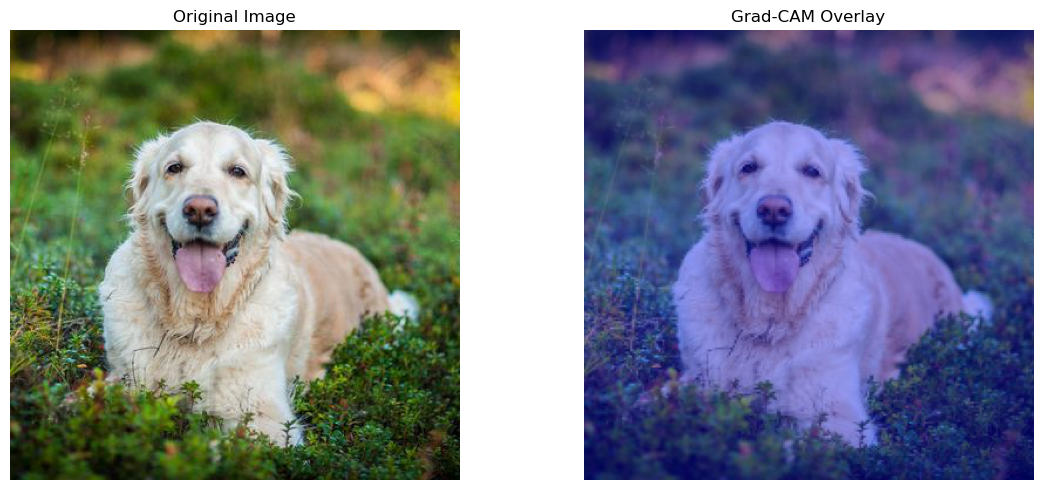

In [3]:
import torch
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set device (ensure you have CUDA-enabled PyTorch installed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create an ImageNet-pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.to(device)
model.eval()

# Define a function to reshape ViT transformer outputs to a 4D tensor
def reshape_transformer_tensors(tensor):
    # Remove the CLS token (first token)
    activations = tensor[:, 1:, :]  
    # For ViT-base with 224x224 and patch size 16, tokens form a 14x14 grid
    activations = activations.view(activations.shape[0], 14, 14, activations.shape[-1])
    # Permute to get [batch, channels, height, width]
    activations = activations.permute(0, 3, 1, 2)
    return activations

# Select a target layer (experiment with norm1, norm2, or mlp for best results)
target_layer = [model.blocks[-1].norm2]

# Initialize GradCAM without the use_cuda parameter
cam = GradCAM(model=model,
              target_layers=target_layer,
              reshape_transform=reshape_transformer_tensors)

# Load and preprocess an input image (replace 'sample_dog.jpg' with your image file)
image_path = 'sample_dog.jpg'
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise ValueError("Check your image path; the image could not be loaded.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))
img_float = np.float32(img_resized) / 255.0  # for overlay display

# Define preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img_resized).unsqueeze(0).to(device)

# Get the model's top predicted class
with torch.no_grad():
    output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Generate Grad-CAM heatmap for the predicted class
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets,
                    aug_smooth=True, eigen_smooth=True)
grayscale_cam = grayscale_cam[0, :]  # take the first image in the batch

# Overlay the Grad-CAM heatmap on the original image
cam_image = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

# Plot the original image and the Grad-CAM overlay
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


### GradCAM (2nd Try)

In [6]:
import torch, cv2
import numpy as np
from PIL import Image
# Load a pre-trained ViT model (e.g., DeiT from Facebook Research via torch.hub)
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = torch.hub.load('facebookresearch/deit:main', 
                       'deit_base_patch16_224', pretrained=True)
model.eval()  # set model to inference mode

# Choose the target layer for Grad-CAM (one of the last transformer blocks, before the final classification).
# Using an intermediate layer is important because the final layer’s class token alone determines output 
# and patch embeddings at the final layer may not directly affect the output&#8203;:contentReference[oaicite:4]{index=4}.
target_layer = model.blocks[-1].norm1  # use the Norm just before the last attention block (for ViT)

# Preprocess the input image
img = Image.open("sample_dog.jpg")  # example image path (e.g., a dog photo)
img = img.resize((224, 224))
# Convert PIL image to numpy and then to tensor
img_np = np.array(img)[:, :, ::-1]  # if you want to use cv2 later (BGR), otherwise keep RGB
img_tensor = torch.tensor(img_np / 255.0).permute(2, 0, 1).unsqueeze(0).float()
# Note: Ensure normalization (using ImageNet mean/std). Here we assume model expects [0,1] normalized input.
# If using torchvision/timm, better to use their transforms:
# from torchvision import transforms; img_tensor = transforms.ToTensor()(img).unsqueeze(0)
# Then normalize: transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img_tensor)


Using cache found in C:\Users\mrnai/.cache\torch\hub\facebookresearch_deit_main
C:\Users\mrnai\.conda\envs\DOG_EMOTION_WIN\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
C:\Users\mrnai\.conda\envs\DOG_EMOTION_WIN\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\mrnai/.cache\torch\hub\facebookresearch_deit_main\models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs

In [8]:
# Prepare storage for gradients and activations
activations = {}
grads = {}

# Define forward hook function to save activations
def forward_hook(module, input, output):
    activations['value'] = output.detach()

# Define backward hook function to save gradients
def backward_hook(module, grad_input, grad_output):
    grads['value'] = grad_output[0].detach()  # grad_output is a tuple, we want the grad wrt output

In [10]:
# Register hooks on the target layer
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_full_backward_hook(backward_hook)

In [12]:
# Instead of using torch.no_grad() for the forward pass,
# directly compute the output to enable gradient tracking:
outputs = model(input_tensor)  # remove torch.no_grad() here
pred_class = outputs.argmax(dim=1).item()

# Backpropagate for the top-1 class score
score = outputs[0, pred_class]  # scalar tensor of the top class logit
model.zero_grad()
score.backward()  # now gradients will be computed

In [14]:


# Get the captured activations and gradients
acts = activations['value']       # shape [1, 197, C] (including class token)
grads_val = grads['value']        # shape [1, 197, C]

# Remove the class token (index 0) and reshape to spatial grid
patch_acts = acts[:, 1:, :]      # shape [1, 196, C] for 14x14 patches
patch_grads = grads_val[:, 1:, :]# shape [1, 196, C]
# Reshape to [batch, channels, 14, 14] 
# (We know 196 patches form a 14x14 grid for a 224x224 image with 16x16 patches)
patch_acts = patch_acts.reshape(1, 14, 14, patch_acts.size(-1))
patch_acts = patch_acts.permute(0, 3, 1, 2)  # shape [1, C, 14, 14]

# Compute Grad-CAM: weight each channel by the average gradient for that channel
weights = patch_grads.mean(dim=1).mean(dim=0)  # average over the 196 patch locations -> shape [C]
# weight the activation maps by the weights and sum up (channel-wise weighted sum)
cam_map = (weights.view(1, -1, 1, 1) * patch_acts).sum(dim=1)  # shape [1, 14, 14]
cam_map = torch.relu(cam_map)        # Apply ReLU to focus on positive influence
cam_map = cam_map.squeeze().cpu().numpy()  # shape [14, 14] numpy array

# Upsample the CAM to full image size (224x224) using interpolation
cam_map_resized = cv2.resize(cam_map, (224, 224), interpolation=cv2.INTER_CUBIC)
# Normalize the heatmap to [0,1]
cam_map_resized = cam_map_resized - cam_map_resized.min()
cam_map_resized = cam_map_resized / (cam_map_resized.max() + 1e-8)


In [16]:
# Convert the original image to float32 and normalize to [0,1]
orig_img = img_np.astype(np.float32) / 255.0  # shape [224,224,3], in BGR format currently
# If img_np was kept in RGB, ensure to use matching color format for heatmap blending.

# Convert CAM to heatmap in BGR format using a colormap
heatmap = cv2.applyColorMap(np.uint8(255 * cam_map_resized), cv2.COLORMAP_JET)
heatmap = heatmap.astype(np.float32) / 255.0  # now in [0,1]

# Blend heatmap with the original image
alpha = 0.5  # transparency for heatmap
overlay = heatmap * alpha + orig_img * (1 - alpha)

# If needed, convert back to RGB for displaying (because we used BGR image with OpenCV):
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Convert to uint8 and save or display the result
overlay_uint8 = np.uint8(255 * overlay)
Image.fromarray(overlay_uint8).save("gradcam_vit_overlay.png")


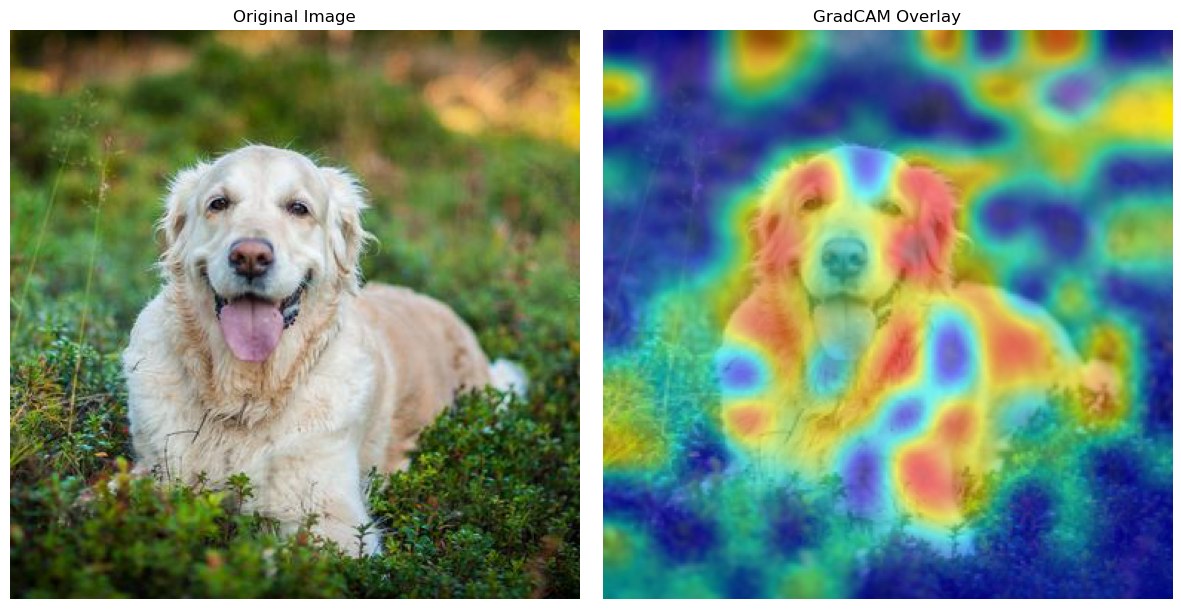

In [23]:
# Create a figure with 1 row, 2 columns to display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(img_rgb)  # original image in [0, 1] range
axes[0].axis('off')  # Turn off axis labels
axes[0].set_title("Original Image")

# Plot the GradCAM overlay image
axes[1].imshow(overlay)  # GradCAM overlay image in [0, 1] range
axes[1].axis('off')  # Turn off axis labels
axes[1].set_title("GradCAM Overlay")

# Show the plot
plt.tight_layout()
plt.show()

### EigenCAM

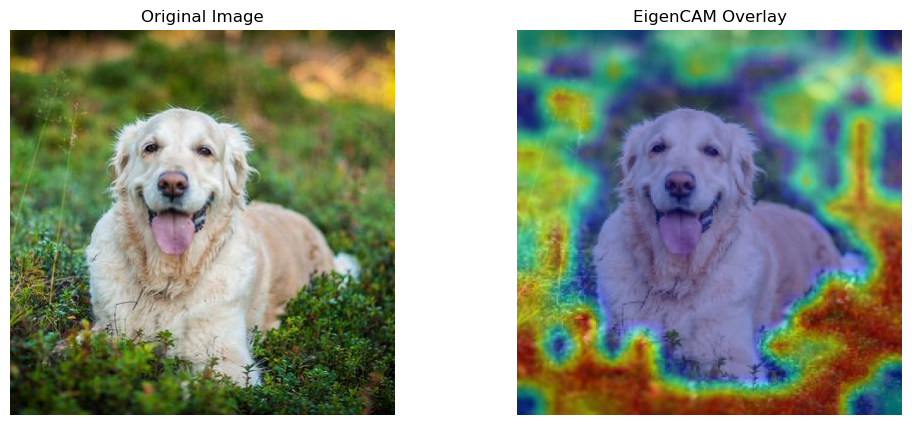

In [25]:
import torch
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# 2. Reshape function for ViT
def reshape_transform(tensor):
    # Remove CLS token, shape [batch, 1+196, channels] -> [batch, 196, channels]
    result = tensor[:, 1:, :]  
    # Reshape 196 -> 14x14
    result = result.reshape(result.shape[0], 14, 14, result.shape[-1])
    # Permute to [batch, channels, height, width]
    result = result.permute(0, 3, 1, 2)
    return result

# 3. Grad-CAM with the final norm2 layer
target_layer = [model.blocks[-1].norm2]
cam = EigenCAM(model=model, target_layers=target_layer, reshape_transform=reshape_transform)

# 4. Load & preprocess image
img_bgr = cv2.imread("sample_dog.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))

# Convert to [0,1] float for overlay
rgb_float = np.float32(img_resized) / 255.0

# Torch transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
input_tensor = transform(img_resized).unsqueeze(0)

# 5. Forward pass to get top-1 class
outputs = model(input_tensor)
pred_class = outputs.argmax(dim=1).item()

# 6. Compute EigenCAM heatmap
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
grayscale_cam = grayscale_cam[0]  # take the first image's cam

# 7. Overlay
cam_image = show_cam_on_image(rgb_float, grayscale_cam, use_rgb=True, image_weight=0.6)

# 8. Display side by side
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title("EigenCAM Overlay")
plt.axis("off")
plt.show()
